In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
import pandas as pd
from prody import *
from tqdm.auto import tqdm
from io import StringIO
from operator import itemgetter
from rdkit import RDLogger 
import numpy as np
from rdkit.Chem.rdMolTransforms import ComputeCentroid
from minisom import MiniSom 
import seaborn as sns
from glob import glob
import os
import useful_rdkit_utils as uru

## 1. Setup

Enable Pandas progress_apply

In [2]:
tqdm.pandas()

A few utility functions to make life easier

In [3]:
def prody_ligand_bond_order(protein, res_name, res_smiles):
    """
    Extract the ligand with the specified residue name from a Prody molecule and assign bond orders
    :param protein: Prody protein
    :param res_name: residue with the ligand
    :param res_smiles: SMILES for the ligand, used for bond order assignment
    :return: RDKit molecule with bond orders assigned
    """
    output = StringIO()
    sub_mol = protein.select(f"resname {res_name}")
    template = AllChem.MolFromSmiles(res_smiles)
    template = uru.get_largest_fragment(template)
    writePDBStream(output, sub_mol)
    pdb_string = output.getvalue()
    rd_mol = AllChem.MolFromPDBBlock(pdb_string)
    RDLogger.DisableLog('rdApp.warning')  
    new_mol = AllChem.AssignBondOrdersFromTemplate(template, rd_mol)
    RDLogger.EnableLog('rdApp.warning')  
    return new_mol

def align_pdbs(mobile, fixed):
    """
    Use Prody to align two molecules
    :param mobile: Prody molecule to be aligned
    :param fixed: Prody molecule to use as a reference for alignment
    :return: aligned mobile molecule as a Prody molecule
    """
    mobile_out,_,_,_,_ = prody.matchAlign(mobile, fixed)
    return mobile_out 



## 2. Reading and Processing Data From the PDB
### 2.1 Read the Input Data
Read the spreadsheet with info on the fragments

In [4]:
df = pd.read_excel("https://raw.githubusercontent.com/PatWalters/datafiles/main/20211124_mac1_pdb_lig.xlsx")

Make Prody less chatty

In [5]:
prody.confProDy(verbosity='warning')

Set up a reference protein to align the other proteins to

In [6]:
ref_prot = prody.parsePDB('5RS7')
ref_prot = ref_prot.select("protein and chain A")

### 2.2 Extract Ligands and Assign Bond Orders
1. Align each protein to the reference
2. Extract the ligand and assign bond orders
3. Build up a list of ligands

In [7]:
rd_ligand_list = []
for p,smi, res in tqdm(df[['PDB','SMILES','Ligand_RESID']].values):
    prot = prody.parsePDB(p).select('not water')
    # break if we can't get the PDB
    if prot is None:
        continue
    # loop over chains and find the first one with the specified ligand
    hv = prot.getHierView()
    for chain in hv:
        if chain.select(f"resname {res}"):
            prot = chain
            break  
    # align to the reference
    prot = align_pdbs(prot, ref_prot)
    # save the aligned pdb
    prody.writePDB(f"{p}_aligned.pdb",prot)
    # get the ligand and assign bond orders
    rd_lig_mol = prody_ligand_bond_order(prot,res,smi)
    rd_lig_mol.SetProp("Name",p)
    rd_lig_mol.SetProp("_Name",p)
    rd_ligand_list.append(rd_lig_mol)

  0%|          | 0/235 [00:00<?, ?it/s]

@> WARNING no one-letter mapping found for <Residue: WOY 201 from Chain A from 5S18 (9 atoms)> 
@> WARNING no one-letter mapping found for <Residue: DMS 202 from Chain A from 5S18 (4 atoms)> 
@> WARNING no one-letter mapping found for <Residue: WPS 201 from Chain A from 5S1A (9 atoms)> 
@> WARNING no one-letter mapping found for <Residue: WPV 201 from Chain A from 5S1C (9 atoms)> 
@> WARNING no one-letter mapping found for <Residue: DMS 202 from Chain A from 5S1C (4 atoms)> 
@> WARNING no one-letter mapping found for <Residue: WPY 201 from Chain A from 5S1E (9 atoms)> 
@> WARNING no one-letter mapping found for <Residue: DMS 202 from Chain A from 5S1E (4 atoms)> 
@> WARNING no one-letter mapping found for <Residue: WQ1 201 from Chain A from 5S1G (9 atoms)> 
@> WARNING no one-letter mapping found for <Residue: WQ4 201 from Chain A from 5S1I (9 atoms)> 
@> WARNING no one-letter mapping found for <Residue: DMS 202 from Chain A from 5S1I (4 atoms)> 
@> WARNING no one-letter mapping found f

@> WARNING no one-letter mapping found for <Residue: NHE 502 from Chain A from 5S3K (13 atoms)> 
@> WARNING no one-letter mapping found for <Residue: JH4 401 from Chain A from 5S3L (8 atoms)> 
@> WARNING no one-letter mapping found for <Residue: S2S 401 from Chain A from 5S3M (14 atoms)> 
@> WARNING no one-letter mapping found for <Residue: W1V 401 from Chain A from 5S3N (12 atoms)> 
@> WARNING no one-letter mapping found for <Residue: W1Y 401 from Chain A from 5S3O (14 atoms)> 
@> WARNING no one-letter mapping found for <Residue: W21 501 from Chain A from 5S3P (13 atoms)> 
@> WARNING no one-letter mapping found for <Residue: W2A 501 from Chain A from 5S3Q (13 atoms)> 
@> WARNING no one-letter mapping found for <Residue: W24 201 from Chain B from 5S3R (15 atoms)> 
@> WARNING no one-letter mapping found for <Residue: W27 401 from Chain A from 5S3S (15 atoms)> 
@> WARNING no one-letter mapping found for <Residue: W2G 401 from Chain A from 5S3T (13 atoms)> 
@> WARNING no one-letter mappin

@> WARNING no one-letter mapping found for <Residue: XIY 201 from Chain A from 5RSR (19 atoms)> 
@> WARNING no one-letter mapping found for <Residue: 5HN 201 from Chain A from 5RST (14 atoms)> 
@> WARNING no one-letter mapping found for <Residue: OHB 201 from Chain A from 5RSU (17 atoms)> 
@> WARNING no one-letter mapping found for <Residue: 4MB 201 from Chain A from 5RSV (22 atoms)> 
@> WARNING no one-letter mapping found for <Residue: 6FZ 201 from Chain A from 5RSW (21 atoms)> 
@> WARNING no one-letter mapping found for <Residue: YTX 201 from Chain A from 5RSX (22 atoms)> 
@> WARNING no one-letter mapping found for <Residue: DMS 202 from Chain A from 5RSX (10 atoms)> 
@> WARNING no one-letter mapping found for <Residue: 3R6 201 from Chain A from 5RSY (19 atoms)> 
@> WARNING no one-letter mapping found for <Residue: ZZA 201 from Chain A from 5RSZ (21 atoms)> 
@> WARNING no one-letter mapping found for <Residue: 4BL 201 from Chain A from 5RT0 (21 atoms)> 
@> WARNING no one-letter mappi

@> WARNING no one-letter mapping found for <Residue: 4FS 201 from Chain A from 5RV4 (19 atoms)> 
@> WARNING no one-letter mapping found for <Residue: JG8 201 from Chain A from 5RV5 (20 atoms)> 
@> WARNING no one-letter mapping found for <Residue: 0HN 201 from Chain A from 5RV6 (17 atoms)> 
@> WARNING no one-letter mapping found for <Residue: JNZ 201 from Chain A from 5RV7 (17 atoms)> 
@> WARNING no one-letter mapping found for <Residue: 8EJ 201 from Chain A from 5RV8 (18 atoms)> 
@> WARNING no one-letter mapping found for <Residue: EKZ 201 from Chain A from 5RV9 (25 atoms)> 
@> WARNING no one-letter mapping found for <Residue: HQD 201 from Chain A from 5RVA (22 atoms)> 
@> WARNING no one-letter mapping found for <Residue: 7PD 201 from Chain A from 5RVB (18 atoms)> 
@> WARNING no one-letter mapping found for <Residue: W7V 201 from Chain A from 5RVC (30 atoms)> 
@> WARNING no one-letter mapping found for <Residue: W7Y 201 from Chain A from 5RVD (36 atoms)> 
@> WARNING no one-letter mappi

Let's see how many ligands we ended up with

In [8]:
len(rd_ligand_list)

235

Save the ligands to a file

In [9]:
writer = Chem.SDWriter("ligs_complete.sdf")
for mol in rd_ligand_list:
    writer.write(mol)
writer.close()

### 2.3 Handle Multiple Ligands
Some of the pdb files have multiple copies of the same ligand bound in different pockets.  Separate these into individual ligands 

In [11]:
frag_mol_list = []
for idx,mol in enumerate(rd_ligand_list,1):
    name = mol.GetProp("Name")
    frag_list = Chem.GetMolFrags(mol,asMols=True)
    for frag_idx,frag in enumerate(frag_list):
        frag.SetProp("Name",name)
        frag.SetProp("Sequence",str(frag_idx))
        frag.SetProp("_Name",name)
        frag_mol_list.append(frag)
print(f"Read {idx} molecules containing {len(frag_mol_list)} fragments")

Read 235 molecules containing 242 fragments


Write the separated ligands to a file

In [12]:
writer = Chem.SDWriter("ligs_separated.sdf")
for mol in frag_mol_list:
    writer.write(mol)
writer.close()

## 3. Calculate the Center of Each Ligand
Create a dataframe with the ligands

In [13]:
lig_df = pd.DataFrame({'ROMol' : frag_mol_list, 
                       'Name': [x.GetProp("Name") for x in frag_mol_list],
                       'Sequence': [x.GetProp("Sequence") for x in frag_mol_list]
                      })

Calculate the geometric center for each ligand

In [14]:
lig_df['center'] = lig_df.ROMol.progress_apply(uru.get_center)

  0%|          | 0/242 [00:00<?, ?it/s]

Create a numpy array containing the ligand centers

In [15]:
X = np.stack(lig_df.center)

## 4. Use a Self-Organizing Map (SOM) to Cluster the Ligands
I've written blog posts [here](http://practicalcheminformatics.blogspot.com/2018/10/self-organizing-maps-90s-fad-or-useful.html) and [here](http://practicalcheminformatics.blogspot.com/2018/10/self-organizing-maps-code-part-2.html) about SOMs, so I won't provide additional background. 

Initialize the SOM

In [16]:
som = MiniSom(5,5,3, random_seed=1)
som.train(X,1000)
cell = [som.winner(i) for i in X]

Create column in the dataframe to hold the cell ids

In [17]:
lig_df['cell'] = cell

In [18]:
lig_df

,ROMol,Name,Sequence,center,cell
0,<rdkit.Chem.rdchem.Mol object at 0x305c8b140>,5S18,0,"[-46.23444444444445, -29.396777777777782, 5.66...","(0, 4)"
1,<rdkit.Chem.rdchem.Mol object at 0x305c8aff0>,5S1A,0,"[-46.644222222222226, -29.43866666666667, 5.49...","(0, 4)"
2,<rdkit.Chem.rdchem.Mol object at 0x305c8aa40>,5S1C,0,"[-51.00444444444444, -29.485555555555557, 7.08...","(0, 1)"
3,<rdkit.Chem.rdchem.Mol object at 0x305c8aab0>,5S1E,0,"[-47.04877777777778, -29.527111111111108, 6.12...","(0, 3)"
4,<rdkit.Chem.rdchem.Mol object at 0x305c8a3b0>,5S1G,0,"[-49.88333333333333, -29.180333333333333, 5.83...","(0, 2)"
...,...,...,...,...,...
237,<rdkit.Chem.rdchem.Mol object at 0x3068e7bc0>,5RVG,0,"[-45.32344444444445, -30.154833333333336, 3.48...","(1, 3)"
238,<rdkit.Chem.rdchem.Mol object at 0x3068e7c30>,5RVG,1,"[-50.29416666666667, -0.5523888888888888, -2.7...","(4, 2)"
239,<rdkit.Chem.rdchem.Mol object at 0x3068e7ca0>,5RVH,0,"[-48.872615384615386, -29.330153846153845, 5.0...","(0, 2)"
240,<rdkit.Chem.rdchem.Mol object at 0x3068e7d10>,5RVI,0,"[-48.14690909090909, -29.143727272727276, 4.17...","(1, 2)"


Create a dataframe to hold the occupied SOM cells

In [19]:
cell_df = lig_df.cell.value_counts().to_frame().reset_index()
cell_df.columns = ["Cell","Count"]

Plot the SOM, the point size is proportional to the number of ligands in a cell.  The numbers adjacent to the points are the cluster ids.  Adjacent cells represent clusters that are close 3D in space (adjacent pockets) on the protein. For instance, clusters 5,4,1, and 6 are adjacent to cluster 0.   

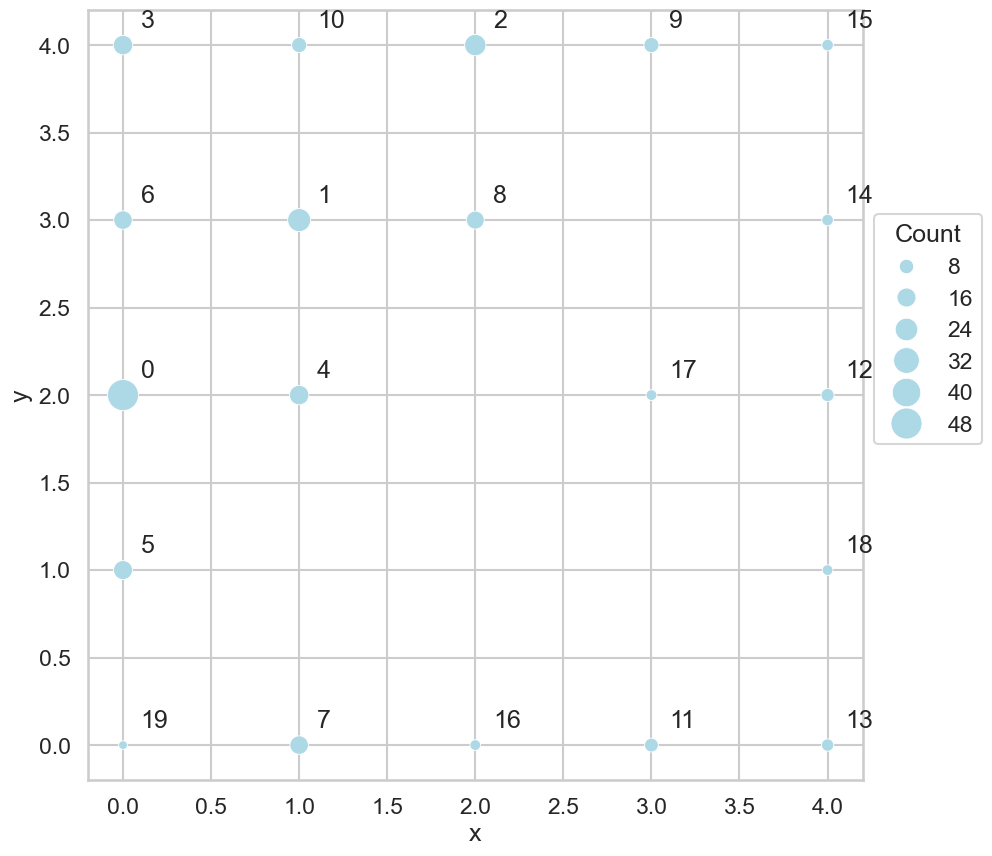

In [20]:
sns.set(rc={'figure.figsize': (10, 10)})
sns.set_style('whitegrid')
sns.set_context('talk')
cell_df['x'] = [x[0] for x in cell_df.Cell]
cell_df['y'] = [x[1] for x in cell_df.Cell]
ax = sns.scatterplot(x="x",y='y',size="Count",data=cell_df,sizes=(40,500),color="lightblue")
ax.legend(title="Count",loc='upper left', bbox_to_anchor=(1.00, 0.75), ncol=1)
cell_df.sort_values('Count',ascending=False)
cell_df['ix'] = range(0,len(cell_df))
for x,y,ix in cell_df[['x','y','ix']].values:
    ax.text(x+0.1,y+0.1,ix)    

Write each cluster to an SD file.  To look at the clusters with PyMol, you can do 
<pre>
pymol 5RS7_aligned.pdb cluster*.sdf
</pre>
Then, in PyMol, execute these commands
<pre>
zoom all
set all_states,on

In [24]:
# delete any files named cluster*.sdf
for filename in glob("som_cluster*.sdf"):
    os.unlink(filename)

# write each cluster as an SDF
for i,x in enumerate(lig_df.cell.value_counts().index):
    cluster_df = lig_df.query("cell == @x")
    filename = f"som_cluster_{i:03d}.sdf"
    print(filename, x, cluster_df.shape[0])
    PandasTools.WriteSDF(cluster_df,filename,properties=["Name","Sequence"])

som_cluster_000.sdf (0, 2) 48
som_cluster_001.sdf (1, 3) 25
som_cluster_002.sdf (2, 4) 21
som_cluster_003.sdf (0, 4) 17
som_cluster_004.sdf (1, 2) 17
som_cluster_005.sdf (0, 1) 16
som_cluster_006.sdf (0, 3) 15
som_cluster_007.sdf (1, 0) 15
som_cluster_008.sdf (2, 3) 14
som_cluster_009.sdf (3, 4) 9
som_cluster_010.sdf (1, 4) 9
som_cluster_011.sdf (3, 0) 7
som_cluster_012.sdf (4, 2) 6
som_cluster_013.sdf (4, 0) 5
som_cluster_014.sdf (4, 3) 4
som_cluster_015.sdf (4, 4) 4
som_cluster_016.sdf (2, 0) 3
som_cluster_017.sdf (3, 2) 3
som_cluster_018.sdf (4, 1) 3
som_cluster_019.sdf (0, 0) 1


## 5. (Extra) Clustering with HDBSCAN

I was reading the post [Geographic Clustering with HDBSCAN](https://towardsdatascience.com/geographic-clustering-with-hdbscan-ef8cb0ed6051) by João Paulo Figueira and though I'd give the approach a try using this dataset.  After all, this data is sort of geographic, right?  Note that number of clusters can be controlled using the parameter **min_cluster_size** in HBDBScan.  Setting this value to a small number gives lots of smaller clusters.  Setting it to a larger value gives a smaller number of large cluster.  Singletons are in cluster -1. 

In [25]:
from hdbscan import HDBSCAN

In [26]:
clusterer = HDBSCAN(min_cluster_size=2, gen_min_span_tree=True)
clusterer.fit(X)

HDBSCAN(gen_min_span_tree=True, min_cluster_size=2)

In [27]:
lig_df['hdbscan'] = clusterer.labels_

In [28]:
lig_df.hdbscan.value_counts()

hdbscan
-1     49
 23    36
 8     26
 9     18
 14    15
 11    11
 2      9
 17     7
 7      7
 21     7
 22     6
 4      6
 15     5
 20     5
 3      5
 10     4
 0      4
 1      4
 18     3
 19     3
 6      3
 5      3
 16     2
 13     2
 12     2
Name: count, dtype: int64

In [29]:
# delete any files named cluster*.sdf
for filename in glob("hdb_cluster*.sdf"):
    os.unlink(filename)

# write each cluster as an SDF
for i,x in enumerate(lig_df.hdbscan.value_counts().index):
    cluster_df = lig_df.query("hdbscan == @x")
    filename = f"hdb_cluster_{i:03d}.sdf"
    print(filename, x, cluster_df.shape[0])
    PandasTools.WriteSDF(cluster_df,filename,properties=["Name","Sequence"])

hdb_cluster_000.sdf -1 49
hdb_cluster_001.sdf 23 36
hdb_cluster_002.sdf 8 26
hdb_cluster_003.sdf 9 18
hdb_cluster_004.sdf 14 15
hdb_cluster_005.sdf 11 11
hdb_cluster_006.sdf 2 9
hdb_cluster_007.sdf 17 7
hdb_cluster_008.sdf 7 7
hdb_cluster_009.sdf 21 7
hdb_cluster_010.sdf 22 6
hdb_cluster_011.sdf 4 6
hdb_cluster_012.sdf 15 5
hdb_cluster_013.sdf 20 5
hdb_cluster_014.sdf 3 5
hdb_cluster_015.sdf 10 4
hdb_cluster_016.sdf 0 4
hdb_cluster_017.sdf 1 4
hdb_cluster_018.sdf 18 3
hdb_cluster_019.sdf 19 3
hdb_cluster_020.sdf 6 3
hdb_cluster_021.sdf 5 3
hdb_cluster_022.sdf 16 2
hdb_cluster_023.sdf 13 2
hdb_cluster_024.sdf 12 2
